# Spam Filtering Challenge - Practical Data Science in Python

This jupyter notebook is part of a deliverable for the Practical Data Science in Python course. The assignment required that I chose a model that could best filter spam text messages.

In [1]:
#import releveant libraries and data
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score,balanced_accuracy_score,confusion_matrix, ConfusionMatrixDisplay 
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

import ssl
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

data_filepath = 'A3_sms.csv'
df = pd.read_csv('A3_sms.csv', sep=',', header=0, index_col = 'Unnamed: 0')
print(df.head())

                                                 sms   spam  profan  \
0  1. Tension face 2. Smiling face 3. Waste face ...  False    True   
1  Hhahhaahahah rofl was leonardo in your room or...  False    True   
4                        Oh for  sake she's in like   False    True   
5  No da:)he is stupid da..always sending like th...  False    True   
6  Lul im gettin some juicy gossip at the hospita...  False    True   

   profan-prob Unnamed: 5  
0     0.950815        NaN  
1     0.933739        NaN  
4     0.879296        NaN  
5     0.873534        NaN  
6     0.869893        NaN  


In [2]:
df = df.drop(columns = 'profan', axis = 1)
df = df.drop(columns = 'profan-prob', axis = 1)
#Theses columns were instructed to be removed as per a course annoucnemnt.

# Data Exploration and Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5351 entries, 0 to 5352
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sms         5351 non-null   object
 1   spam        5351 non-null   bool  
 2   Unnamed: 5  49 non-null     object
dtypes: bool(1), object(2)
memory usage: 130.6+ KB


In [4]:
df.head()

,sms,spam,Unnamed: 5
0,1. Tension face 2. Smiling face 3. Waste face ...,False,NaN
1,Hhahhaahahah rofl was leonardo in your room or...,False,NaN
4,Oh for sake she's in like,False,NaN
5,No da:)he is stupid da..always sending like th...,False,NaN
6,Lul im gettin some juicy gossip at the hospita...,False,NaN


In [5]:
df.value_counts('Unnamed: 5')

Unnamed: 5
********      48
\/\/\/\/\/     1
dtype: int64

In [6]:
placeholder_column = df['Unnamed: 5']
df = df.drop(columns ='Unnamed: 5')

In [7]:
print(df['sms'][df['spam'] == True].drop_duplicates())

11      Do you ever notice that when you're driving, a...
42      cmon babe, make me , ! Txt me  now babe -) Im ...
71      Hey I am really  want to chat or  text hot to ...
140     Dear Dave this is your final notice to collect...
141     okmail: Dear Dave this is your final notice to...
                              ...                        
5347    Congratulations! Thanks to a good friend U hav...
5348    Congratulations! Thanks to a good friend U hav...
5349    Congratulations - Thanks to a good friend U ha...
5350    URGENT! Your mobile number *************** WON...
5351    URGENT! Your Mobile No was awarded a Â£2,000 B...
Name: sms, Length: 602, dtype: object


In [8]:
print(df['sms'][df['spam'] == False].drop_duplicates())

0       1. Tension face 2. Smiling face 3. Waste face ...
1       Hhahhaahahah rofl was leonardo in your room or...
4                             Oh for  sake she's in like 
5       No da:)he is stupid da..always sending like th...
6       Lul im gettin some juicy gossip at the hospita...
                              ...                        
5336    Depends on individual lor e hair dresser say p...
5337    Thanks for your message. I really appreciate y...
5338    I sent my scores to sophas and i had to do sec...
5341    &lt;#&gt;  is fast approaching. So, Wish u a v...
5352    Do whatever you want. You know what the rules ...
Name: sms, Length: 4346, dtype: object


In [9]:
spam = list(df['sms'][df['spam'] == True].drop_duplicates())

In [10]:
ham = list(df['sms'][df['spam'] == False].drop_duplicates())

In [11]:
spamlist = list(spam)
spamlist[0:10]

["Do you ever notice that when you're driving, anyone going slower than you is an idiot and everyone driving faster than you is a maniac?",
 'cmon babe, make me , ! Txt me  now babe -) Im . All replies cost Â£1.50. 2 cancel send STOP',
 'Hey I am really  want to chat or  text hot to 69698 text charged at 150pm to unsubscribe text stop 69698',
 'Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm',
 'okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm',
 'ROMCAPspam Everyone around should be responding well to your presence since you are so warm and outgoing. You are bringing in a real breath of sunshine.',
 "8007 25p 4 Alfie Moon's Children in Need song on ur mob. Tell ur m8s. Txt TONE CHARITY to 8007 for nokias or POLY CHARITY for polys :zed 08701417012 profit 2 charity",
 "5p

In [12]:
hamlist = list(ham)
hamlist[0:10]

['1. Tension face 2. Smiling face 3. Waste face 4. Innocent face 5.Terror face 6.Cruel face 7.Romantic face 8.Lovable face 9.decent face &lt;#&gt; .joker face.',
 'Hhahhaahahah rofl was leonardo in your room or something',
 "Oh for  sake she's in like ",
 'No da:)he is stupid da..always sending like this:)don believe any of those message.pandy is a :)',
 'Lul im gettin some juicy gossip at the hospital.  Oyea.',
 'My planning usually stops at "find hella weed, smoke hella weed"',
 'How dare you stupid. I wont tell anything to you. Hear after i wont talk to you:-.',
 '"HI BABE UAWAKE?FEELLIKW .JUSTFOUND OUT VIA ALETTER THATMUM GOTMARRIED 4thNOV.BEHIND OURBACKS Â– (oofin) NICE!,.ANYWAY,IÂ’L CALL U"',
 'Ho ho - big belly laugh! See ya tomo',
 'I love u 2 babe! R u sure everything is alrite. Is he being an idiot? Txt bak girlie']

I noted that this code was used in the vocareum activities to download punkt and stopwords however it was unneccessary for me to download it as I was using anaconda, I have added it as a comment to note that it may be needed for other IDEs.
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass 
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt') 
nltk.download('stopwords') 
    

In [13]:
prepstopwords = stopwords.words('english')
prepstopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [14]:
spamprep = [sms.lower() for sms in spamlist]
hamprep = [sms.lower() for sms in hamlist]

In [15]:
spamprep = [word_tokenize(sms) for sms in spamprep]
hamprep = [word_tokenize(sms) for sms in hamprep]

In [16]:
print(spamprep[0])
print(hamprep[0])

['do', 'you', 'ever', 'notice', 'that', 'when', 'you', "'re", 'driving', ',', 'anyone', 'going', 'slower', 'than', 'you', 'is', 'an', 'idiot', 'and', 'everyone', 'driving', 'faster', 'than', 'you', 'is', 'a', 'maniac', '?']
['1.', 'tension', 'face', '2.', 'smiling', 'face', '3.', 'waste', 'face', '4.', 'innocent', 'face', '5.terror', 'face', '6.cruel', 'face', '7.romantic', 'face', '8.lovable', 'face', '9.decent', 'face', '&', 'lt', ';', '#', '&', 'gt', ';', '.joker', 'face', '.']


In [17]:
spamprep = [[word for word in sms if not word in prepstopwords] for sms in spamprep] 
hamprep = [[word for word in sms if not word in prepstopwords] for sms in hamprep]
print(spamprep[0]) 
print(hamprep[0]) 

['ever', 'notice', "'re", 'driving', ',', 'anyone', 'going', 'slower', 'idiot', 'everyone', 'driving', 'faster', 'maniac', '?']
['1.', 'tension', 'face', '2.', 'smiling', 'face', '3.', 'waste', 'face', '4.', 'innocent', 'face', '5.terror', 'face', '6.cruel', 'face', '7.romantic', 'face', '8.lovable', 'face', '9.decent', 'face', '&', 'lt', ';', '#', '&', 'gt', ';', '.joker', 'face', '.']


In [18]:
# Make a data visualisation here

In [19]:
len(spam)

602

In [20]:
len(ham)

4346

Text(0.5, 1.0, 'Distribution of Target Variable')

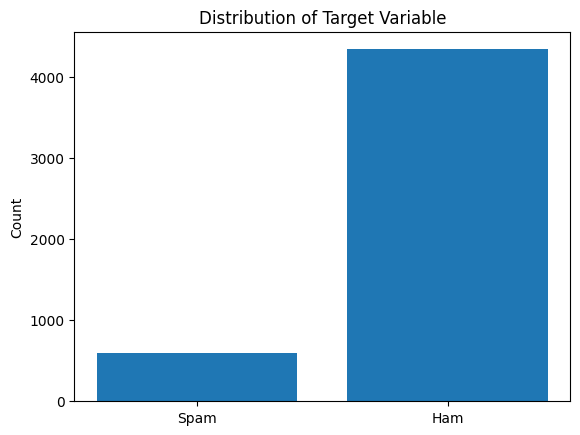

In [21]:
ax = plt.subplot()
plt.bar(x = ['Spam', 'Ham'], height = [len(spam), len(ham)])
ax.set_ylabel("Count")
plt.title("Distribution of Target Variable")

Significantly imbalanced data suggests that minority sample techniques SMOTE might be applicable.

# Data Preprocessing Using Count Vectorizer

In [22]:
CountVec = CountVectorizer(lowercase=True,analyzer='word',stop_words='english') 

In [23]:
feature_vectors = CountVec.fit_transform(ham + spam) 

## Creating a base Train/Test Split

The project will create a train test split as raw (Imbalanced) and then will create a Train/Test Split using Smote.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, [0] * len(ham) + [1] * len(spam), random_state = 7, test_size=0.2)


X_train_smote, y_train_smote =SMOTE().fit_resample(X_train, y_train)

# K Nearest Neighbors

In [25]:
KNN = KNeighborsClassifier()
#n_neighbours needs to be odd numbered to avoid ties for classification
hyperparametersforKNN = {'n_neighbors' :[1, 3, 5, 7, 9, 11],
                        'p': [1,2]}
kneighbors = GridSearchCV(KNN, hyperparametersforKNN, scoring ='accuracy', refit = True, n_jobs=-1)

In [26]:
kneighbors.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11], 'p': [1, 2]},
             scoring='accuracy')

In [27]:
knnresults = pd.DataFrame(kneighbors.cv_results_)
knnresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001059,0.000014,0.173004,0.007963,1,1,"{'n_neighbors': 1, 'p': 1}",0.931818,0.933081,0.933081,0.938053,0.944374,0.936081,0.004666,2
1,0.001975,0.001756,0.042930,0.004994,1,2,"{'n_neighbors': 1, 'p': 2}",0.938131,0.933081,0.934343,0.940582,0.948167,0.938861,0.005365,1
2,0.004066,0.002169,0.210929,0.015451,3,1,"{'n_neighbors': 3, 'p': 1}",0.911616,0.914141,0.910354,0.911504,0.921618,0.913847,0.004078,4
3,0.003073,0.001459,0.069697,0.009339,3,2,"{'n_neighbors': 3, 'p': 2}",0.916667,0.915404,0.915404,0.912769,0.924147,0.916878,0.003850,3
4,0.003615,0.002294,0.186513,0.009281,5,1,"{'n_neighbors': 5, 'p': 1}",0.900253,0.900253,0.905303,0.905183,0.907712,0.903741,0.002988,6
5,0.003479,0.001781,0.042579,0.004571,5,2,"{'n_neighbors': 5, 'p': 2}",0.902778,0.902778,0.907828,0.903919,0.908976,0.905256,0.002628,5
6,0.001956,0.000516,0.193258,0.010642,7,1,"{'n_neighbors': 7, 'p': 1}",0.891414,0.888889,0.897727,0.898862,0.888748,0.893128,0.004339,8
7,0.002700,0.001887,0.056226,0.005709,7,2,"{'n_neighbors': 7, 'p': 2}",0.895202,0.890152,0.898990,0.897598,0.895070,0.895402,0.003014,7
8,0.001954,0.001068,0.184280,0.011394,9,1,"{'n_neighbors': 9, 'p': 1}",0.888889,0.883838,0.886364,0.886220,0.887484,0.886559,0.001664,10
9,0.003097,0.001998,0.049214,0.007696,9,2,"{'n_neighbors': 9, 'p': 2}",0.888889,0.885101,0.891414,0.888748,0.890013,0.888833,0.002097,9


In [28]:
kneighbors.best_score_

0.9388607950554853

In [29]:
kneighbors.best_estimator_

KNeighborsClassifier(n_neighbors=1)

In [30]:
KNeighborparameter = pd.DataFrame({'parameters': kneighbors.cv_results_["params"], 'accuracy': kneighbors.cv_results_["mean_test_score"]})
KNeighborparameter

,parameters,accuracy
0,"{'n_neighbors': 1, 'p': 1}",0.936081
1,"{'n_neighbors': 1, 'p': 2}",0.938861
2,"{'n_neighbors': 3, 'p': 1}",0.913847
3,"{'n_neighbors': 3, 'p': 2}",0.916878
4,"{'n_neighbors': 5, 'p': 1}",0.903741
5,"{'n_neighbors': 5, 'p': 2}",0.905256
6,"{'n_neighbors': 7, 'p': 1}",0.893128
7,"{'n_neighbors': 7, 'p': 2}",0.895402
8,"{'n_neighbors': 9, 'p': 1}",0.886559
9,"{'n_neighbors': 9, 'p': 2}",0.888833


according to this N = 1 and P = 2 result is the best parameters

In [31]:
results = pd.DataFrame()

In [32]:
predicted_knn = kneighbors.predict(X_test)

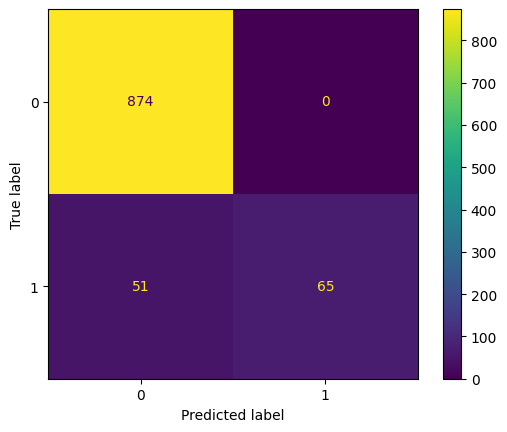

In [33]:
cm = confusion_matrix(y_test, predicted_knn, labels=kneighbors.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kneighbors.classes_)
disp.plot()

#### Accuracy

In [34]:
results.loc['kneighbors','Accuracy']=accuracy_score(y_test,predicted_knn) 

print(results.loc['kneighbors','Accuracy']) 

0.9484848484848485


#### Balanced Accuracy

In [35]:
results.loc['kneighbors','Balanced Accuracy']=balanced_accuracy_score(y_test,predicted_knn) 

print(results.loc['kneighbors','Balanced Accuracy']) 

0.7801724137931034


#### Training Time in Seconds (s)

In [36]:
results.loc['kneighbors','Training Time']=kneighbors.cv_results_['mean_fit_time'].mean() 

print(results.loc['kneighbors','Training Time']) 

0.0028375665346781413


#### Prediction Time (s) per sms

In [37]:
results.loc['kneighbors','Prediction Time']=kneighbors.cv_results_['mean_score_time'].mean()/len(y_test) 

print(results.loc['kneighbors','Prediction Time']) 

0.00012047559725315081


## KNN SMOTE

In [38]:
#setting up the parameters for the SMOTE KNN learning trials.
KNNSMOTE = GridSearchCV(KNN, hyperparametersforKNN, scoring ='accuracy', refit = True, n_jobs=-1)
KNNSMOTE.fit(X_train_smote, y_train_smote)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11], 'p': [1, 2]},
             scoring='accuracy')

In [39]:
KNNSMOTEresults = pd.DataFrame(KNNSMOTE.cv_results_)
KNNSMOTEresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003697,0.001816,0.913983,0.078656,1,1,"{'n_neighbors': 1, 'p': 1}",0.863211,0.770338,0.813535,0.785457,0.782421,0.802992,0.033270,2
1,0.002439,0.002064,0.136608,0.015844,1,2,"{'n_neighbors': 1, 'p': 2}",0.868970,0.772498,0.811375,0.784017,0.782421,0.803856,0.035022,1
2,0.001920,0.000802,0.991279,0.084201,3,1,"{'n_neighbors': 3, 'p': 1}",0.838733,0.737221,0.790497,0.760259,0.754323,0.776207,0.035684,4
3,0.001834,0.000911,0.201882,0.013975,3,2,"{'n_neighbors': 3, 'p': 2}",0.842333,0.741541,0.789777,0.758099,0.757925,0.777935,0.035793,3
4,0.001502,0.000113,0.779834,0.043423,5,1,"{'n_neighbors': 5, 'p': 1}",0.622030,0.601872,0.624190,0.627790,0.627522,0.620681,0.009646,6
5,0.001345,0.000146,0.110781,0.022449,5,2,"{'n_neighbors': 5, 'p': 2}",0.652268,0.624910,0.648668,0.631389,0.654179,0.642283,0.011853,5
6,0.002437,0.000866,0.871162,0.074651,7,1,"{'n_neighbors': 7, 'p': 1}",0.582433,0.576674,0.596112,0.593233,0.586455,0.586981,0.007066,9
7,0.001948,0.001039,0.123060,0.023227,7,2,"{'n_neighbors': 7, 'p': 2}",0.611951,0.602592,0.622030,0.604752,0.621758,0.612617,0.008185,7
8,0.002801,0.001991,0.838039,0.083808,9,1,"{'n_neighbors': 9, 'p': 1}",0.556515,0.561555,0.568754,0.565875,0.565562,0.563652,0.004241,11
9,0.001354,0.000110,0.120255,0.015143,9,2,"{'n_neighbors': 9, 'p': 2}",0.584593,0.582433,0.599712,0.586033,0.603746,0.591304,0.008683,8


In [40]:
predictedSMOTEKNN = KNNSMOTE.predict(X_test)

#### Confusion Matrix

Text(0.5, 1.0, 'KNN with SMOTE')

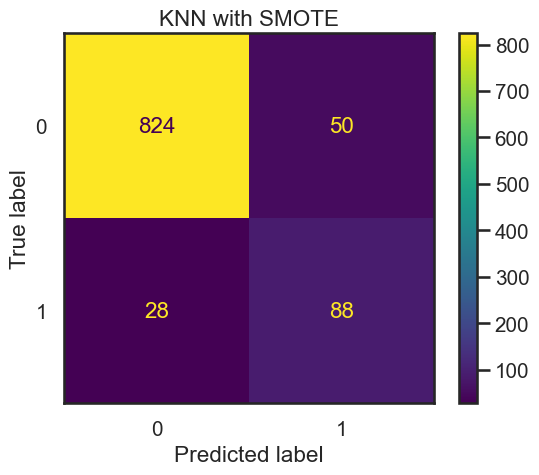

In [75]:
cm = confusion_matrix(y_test, predictedSMOTEKNN, labels=kneighbors.classes_) 
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kneighbors.classes_) 
disp2.plot() 
plt.title("KNN with SMOTE")

#### Accuracy

In [76]:
results.loc['KNNSMOTE','Accuracy']=accuracy_score(y_test,predictedSMOTEKNN) 

print(results.loc['KNNSMOTE','Accuracy']) 

0.9212121212121213


#### Balanced Accuracy

In [77]:
results.loc['KNNSMOTE','Balanced Accuracy']=balanced_accuracy_score(y_test,predictedSMOTEKNN) 

print(results.loc['KNNSMOTE','Balanced Accuracy']) 

0.8507062258344511


#### Training Time (s)

In [78]:
results.loc['KNNSMOTE','Training Time']=kneighbors.cv_results_['mean_fit_time'].mean() 

print(results.loc['KNNSMOTE','Training Time']) 

0.0028375665346781413


#### Prediction Time (s) per sms

In [79]:
results.loc['KNNSMOTE','Prediction Time']=kneighbors.cv_results_['mean_score_time'].mean()/len(y_test) 

print(results.loc['KNNSMOTE','Prediction Time']) 

0.00012047559725315081


# Decision Tree Analysis

In [80]:
tree = DecisionTreeClassifier()

In [81]:
treeparam = {
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf':[5, 10, 20, 50, 100],
    'max_depth':[2, 3, 5, 10, 20]}

In [82]:
tree = GridSearchCV(tree, treeparam, scoring = 'accuracy')

In [83]:
tree.fit(X_train, y_train)
treedata = pd.DataFrame(tree.cv_results_)
treedata

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025295,0.003462,0.000656,0.000046,2,5,2,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.916667,0.919192,0.917929,0.916561,0.916561,0.917382,0.001043,49
1,0.023216,0.000402,0.000534,0.000013,2,5,3,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.916667,0.919192,0.917929,0.916561,0.916561,0.917382,0.001043,49
2,0.022953,0.000450,0.000484,0.000022,2,5,5,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.916667,0.919192,0.917929,0.916561,0.916561,0.917382,0.001043,49
3,0.022897,0.000407,0.000479,0.000016,2,10,2,"{'max_depth': 2, 'min_samples_leaf': 10, 'min_...",0.916667,0.919192,0.917929,0.916561,0.916561,0.917382,0.001043,49
4,0.022897,0.000489,0.000483,0.000036,2,10,3,"{'max_depth': 2, 'min_samples_leaf': 10, 'min_...",0.916667,0.919192,0.917929,0.916561,0.916561,0.917382,0.001043,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.042853,0.021440,0.000654,0.000081,20,50,3,"{'max_depth': 20, 'min_samples_leaf': 50, 'min...",0.931818,0.933081,0.933081,0.929204,0.941846,0.933806,0.004262,28
71,0.030430,0.000779,0.000598,0.000058,20,50,5,"{'max_depth': 20, 'min_samples_leaf': 50, 'min...",0.931818,0.933081,0.933081,0.929204,0.941846,0.933806,0.004262,28
72,0.025884,0.000684,0.000480,0.000033,20,100,2,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.898990,0.895202,0.888889,0.887484,0.901391,0.894391,0.005455,61
73,0.026088,0.000576,0.000695,0.000207,20,100,3,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.898990,0.895202,0.888889,0.887484,0.901391,0.894391,0.005455,61


In [84]:
treepredict = tree.predict(X_test)

#### Confusion Matrix

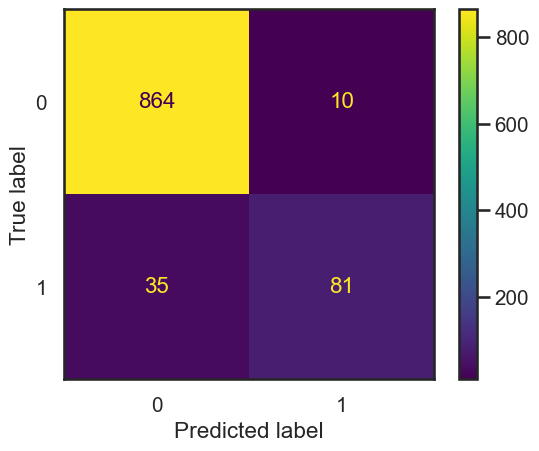

In [85]:
cm3 = confusion_matrix(y_test, treepredict, labels = tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=tree.classes_)
disp.plot()

#### Accuracy

In [86]:
results.loc['Decision Tree','Accuracy']=accuracy_score(y_test,treepredict) 
print(results.loc['Decision Tree','Accuracy']) 

0.9545454545454546


#### Balanced Accuracy

In [87]:
results.loc['Decision Tree', 'Balanced Accuracy'] = balanced_accuracy_score(y_test, treepredict)
print(results.loc['Decision Tree', 'Balanced Accuracy'])

0.8434171072358558


#### Training time (s)

In [88]:
results.loc['Decision Tree','Training Time']=tree.cv_results_['mean_fit_time'].mean() 
print(results.loc['Decision Tree','Training Time']) 

0.02610686111450195


#### Prediction Time (s) per sms

In [89]:
results.loc['Decision Tree','Prediction Time']=tree.cv_results_['mean_score_time'].mean()/len(y_test) 
print(results.loc['Decision Tree','Prediction Time']) 

5.490864968861794e-07


# SMOTE w/ Decision Tree

In [90]:
smotetree = DecisionTreeClassifier()
smotetree = GridSearchCV(smotetree, treeparam, scoring = 'accuracy')
smotetree.fit(X_train_smote, y_train_smote) 

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'min_samples_split': [2, 3, 5]},
             scoring='accuracy')

In [91]:
smotetreeresults = pd.DataFrame(smotetree.cv_results_)
smotetreeresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020289,0.000813,0.000838,0.000099,2,5,2,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.613391,0.574514,0.574514,0.579554,0.587896,0.585974,0.014555,61
1,0.019525,0.000815,0.000799,0.000074,2,5,3,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.613391,0.574514,0.574514,0.579554,0.587896,0.585974,0.014555,61
2,0.019717,0.001316,0.000752,0.000071,2,5,5,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.613391,0.574514,0.574514,0.579554,0.587896,0.585974,0.014555,61
3,0.018892,0.000981,0.000746,0.000103,2,10,2,"{'max_depth': 2, 'min_samples_leaf': 10, 'min_...",0.613391,0.574514,0.574514,0.579554,0.587896,0.585974,0.014555,61
4,0.018651,0.000937,0.000650,0.000037,2,10,3,"{'max_depth': 2, 'min_samples_leaf': 10, 'min_...",0.613391,0.574514,0.574514,0.579554,0.587896,0.585974,0.014555,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.030791,0.001464,0.000732,0.000048,20,50,3,"{'max_depth': 20, 'min_samples_leaf': 50, 'min...",0.685385,0.701224,0.703384,0.714183,0.711816,0.703198,0.010160,22
71,0.030660,0.001400,0.000710,0.000046,20,50,5,"{'max_depth': 20, 'min_samples_leaf': 50, 'min...",0.685385,0.701224,0.703384,0.714183,0.711816,0.703198,0.010160,22
72,0.027065,0.001365,0.000683,0.000056,20,100,2,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.748020,0.665947,0.678906,0.692585,0.673631,0.691818,0.029415,25
73,0.027021,0.001283,0.000711,0.000105,20,100,3,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.748020,0.665947,0.678906,0.692585,0.673631,0.691818,0.029415,25


In [92]:
smotetreepredict = smotetree.predict(X_test)

#### Conufsion Matrix

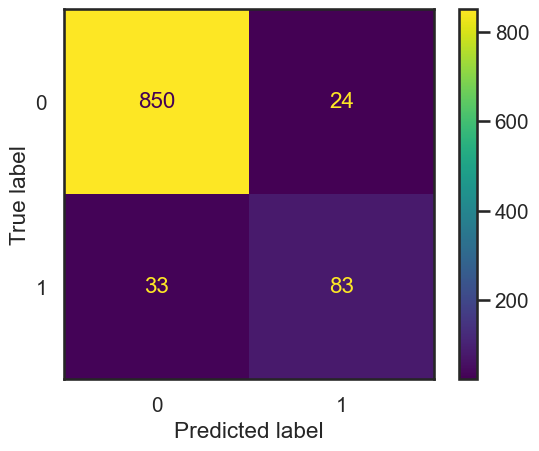

In [93]:
cm4 = confusion_matrix(y_test, smotetreepredict, labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=smotetree.classes_)
disp.plot()

#### Accuracy

In [94]:
results.loc['DT SMOTE','Accuracy']=accuracy_score(y_test,smotetreepredict) 
print(results.loc['DT SMOTE','Accuracy']) 

0.9424242424242424


#### Balanced Accuracy

In [95]:
results.loc['DT SMOTE','Balanced Accuracy']=balanced_accuracy_score(y_test,smotetreepredict) 
print(results.loc['DT SMOTE','Balanced Accuracy']) 

0.8440286435729504


#### Training Time (s)

In [96]:
results.loc['DT SMOTE','Training Time']=smotetree.cv_results_['mean_fit_time'].mean() 
print(results.loc['DT SMOTE','Training Time']) 

0.023764897028605143


#### Prediction Time (s)

In [97]:
results.loc['DT SMOTE','Prediction Time']=smotetree.cv_results_['mean_fit_time'].mean()/len(y_test)
print(results.loc['DT SMOTE','Prediction Time']) 

2.400494649354055e-05


# Model Comparison

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
results

,Accuracy,Balanced Accuracy,Training Time,Prediction Time
kneighbors,0.948485,0.780172,0.002838,1.204756e-04
KNNSMOTE,0.921212,0.850706,0.002838,1.204756e-04
Decision Tree,0.954545,0.843417,0.026107,5.490865e-07
DT SMOTE,0.942424,0.844029,0.023765,2.400495e-05


In [100]:
(results['Balanced Accuracy'][1]) - (results['Balanced Accuracy'][2])

0.007289118598595268

In [101]:
a = (results['Prediction Time'][1])
b = results['Prediction Time'][2]
a/b

219.4109633661676

Text(0.5, 1.0, 'Accuracy % Between Tests')

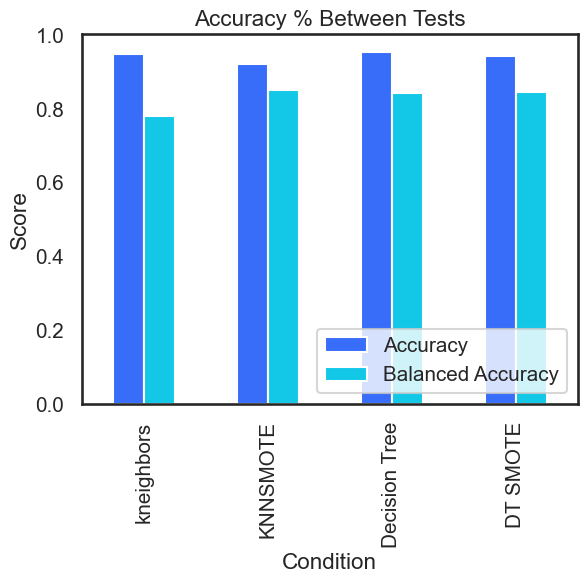

In [102]:
sns.set_style('white')
sns.set_context('talk', font_scale=0.9)
sns.set_palette('rainbow')
results[['Accuracy','Balanced Accuracy']].plot(kind="bar") 
plt.xlabel('Condition')
plt.ylabel('Score')
plt.legend(loc = 4)
plt.title('Accuracy % Between Tests')

Text(0.5, 1.0, 'Training Time in Seconds')

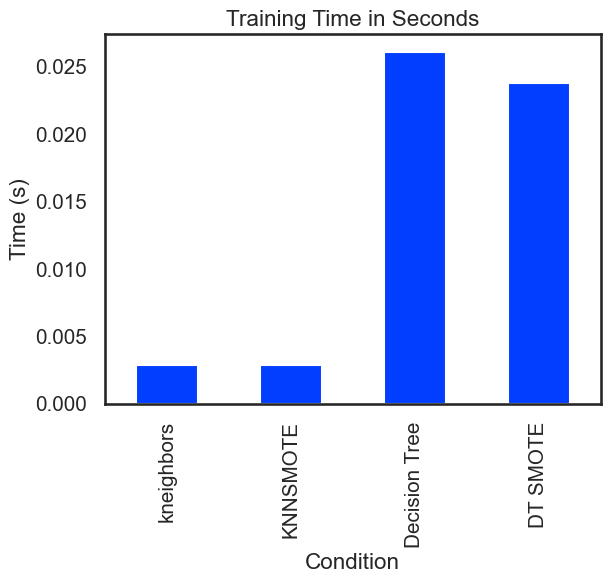

In [103]:
sns.set_style('white')
sns.set_context('talk', font_scale=0.9)
sns.set_palette('bright')
results[['Training Time']].plot(kind="bar") 
plt.legend('',frameon=False)
plt.xlabel('Condition')
plt.ylabel('Time (s)')
plt.title('Training Time in Seconds')

Text(0.5, 1.0, 'Prediction Time in Seconds')

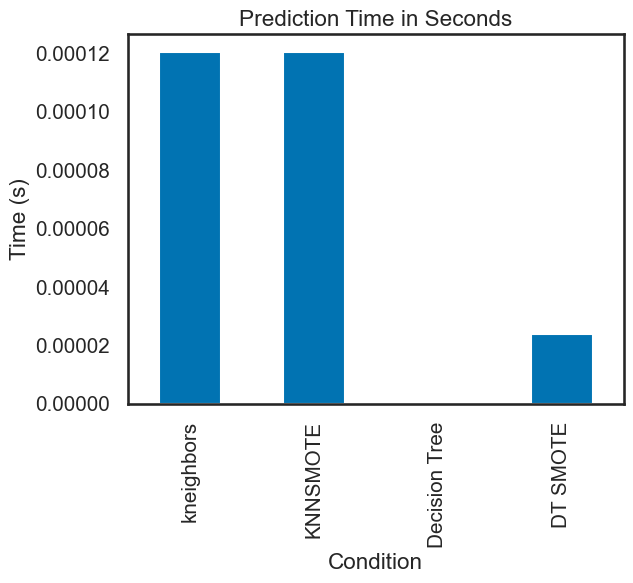

In [104]:
sns.set_style('white')
sns.set_context('talk', font_scale=0.9)
sns.set_palette('colorblind')
results[['Prediction Time']].plot(kind="bar") 
plt.legend('',frameon=False)
plt.xlabel('Condition')
plt.ylabel('Time (s)')
plt.title('Prediction Time in Seconds')

Text(0.5, 1.0, 'KNeighbors')

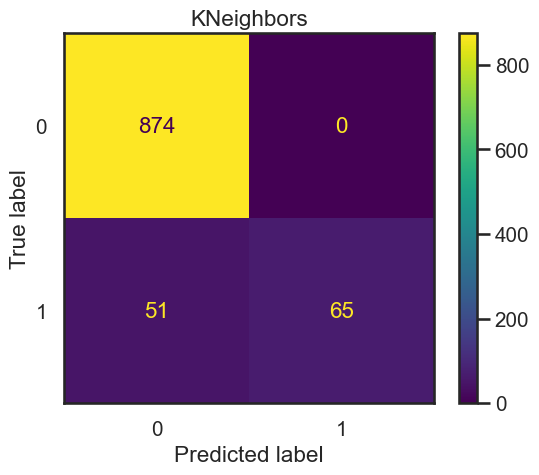

In [105]:
cm = confusion_matrix(y_test, predicted_knn, labels=kneighbors.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kneighbors.classes_)
disp.plot()
plt.title('KNeighbors')

Text(0.5, 1.0, 'KNeighbors w/SMOTE')

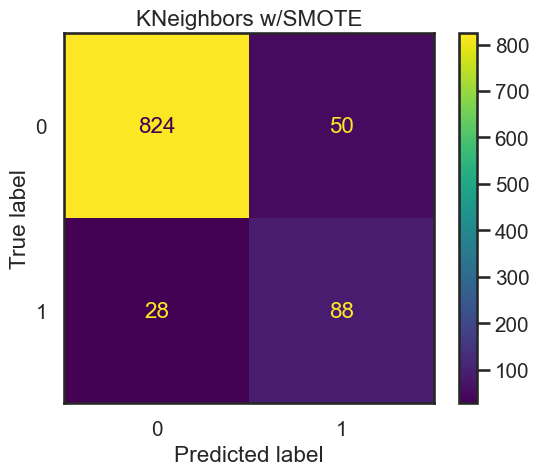

In [106]:
cm = confusion_matrix(y_test, predictedSMOTEKNN, labels=kneighbors.classes_) 
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kneighbors.classes_) 
disp2.plot() 
plt.title('KNeighbors w/SMOTE')

Text(0.5, 1.0, 'Decision Tree')

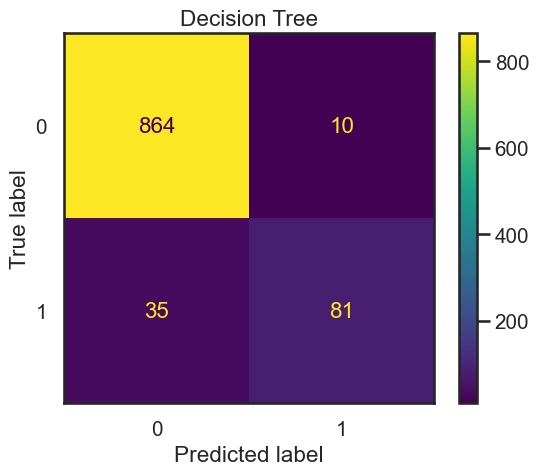

In [107]:
cm3 = confusion_matrix(y_test, treepredict, labels = tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=tree.classes_)
disp.plot()
plt.title('Decision Tree')

Text(0.5, 1.0, 'Decision Tree w/SMOTE')

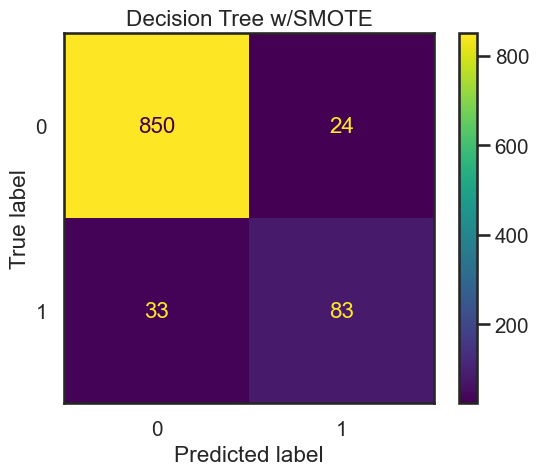

In [108]:
cm4 = confusion_matrix(y_test, smotetreepredict, labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=smotetree.classes_)
disp.plot()
plt.title('Decision Tree w/SMOTE')

# Conclusion

KNN with SMOTE performed consierably better whilst it did not appear to have a significant impact on the decision tree algorithm. To answer the business question,
the decision tree model with smote has a comparable metric to KNN with SMOTE whilst having a much faster prediction time. Therefore due to the scale of the amount of sent/received text messages I would recommend the Decision Tree Model with SMOTE to improve the SPAM problem.